# 多变量线性回归

在本次作业中目的在于使用梯度下降法（随机梯度下降法）的多变量线性回归模型。你将探讨损失函数、梯度下降法的收敛、过拟合问题和学习率等之间的关系。


## 作业概述

请在文件夹“作业2”中下载文件名为“dataForTraining.txt”的文件。该文件包含广东省广州市海珠区的房价信息，里面包含50个训练样本数据。文件有三列，第一列对应房的面积（单位：平方米），第二列对应房子距离双鸭山职业技术学院的距离（单位：千米），第三列对应房子的销售价格（单位：万元）。每一行对应一个训练样本。请使用提供的50个训练样本来训练多变量回归模型以便进行房价预测，请用（随机）梯度下降法的多变量线性回归模型进行建模。为了评估训练效果，请文件夹中下载测试数据集“dataForTesting.txt” 


## 准备流程

### 读取数据
首先需要把题目中的数据，导入到程序中，这次的数据包括两个部分，一个部分是训练集，另一个是测试集，每一个文件内部的结构都是类似的。导入文件之后的流程都是类似的。

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

def load_data(file_name):
    """
    load data from file
    return vale:
    - X: a matrix for trainning data with shape of m * 2 where m is the number of samples 
    - y: label
    """
    mat = []
    with open(file_name, "r") as f:
        while 1:  
            line = f.readline()
            if len(line) == 0: 
                break
            elements = [float(e) for e in line.split()]
            mat.append(elements)
    res = np.array(mat)
    return res[:,  : 2], res[:, 2]

training_X, training_y = load_data("dataForTraining.txt")
test_X, test_y = load_data("dataForTesting.txt")

sample_num, feature_num = training_X.shape
training_X = np.column_stack((np.ones((sample_num)),training_X))
training_y = training_y.reshape(sample_num, 1)

test_X = np.column_stack((np.ones((test_X.shape[0])),test_X))
test_y = test_y.reshape(test_y.shape[0], 1)

# w_0 for bias term, w_1 ... w_n for coefficient of feature 
w0 = np.zeros((feature_num + 1, 1))
print("meta data of test data : ", test_X.dtype, test_X.shape, test_y.shape)
print("meta data of training data : ", training_X.dtype, training_X.shape, training_y.shape)

meta data of test data :  float64 (10, 3) (10, 1)
meta data of training data :  float64 (50, 3) (50, 1)


### 定义工具函数

根据要求题目的要求，需要以下函数来辅助后面的模型训练。

- loss_func：定义损失函数，值得注意的，这里没有直接使用 PPT 中提供的对数最大似然的损失函数，而是在前面加上了 $\frac{1}{2n}$ 的权重 主要是基于以下考虑:

    - 损失函数还可以从最小二乘的方向来解释，求各个点偏差的均值不会影响梯度的训练，因为后面同样使用了这个函数来评价模型的好坏，模型的好坏不应该被测试样本的数量的影响（如果没有算均值的话，越多的样本会导致越高的误差）
    
    - 加上 1/2 是为了方便之后的计算
    
- get_gradient： 用来根据给定的参数，来计算对应的被训练值的梯度。

In [6]:
# 定义损失函数 
def loss_func(w, X = training_X, y = training_y):
    n, _ = X.shape
    return np.sum(np.square(X @ w - y)) / (2 * n)

# 计算梯度
def get_gradient(w, X, y):
    n, _ = X.shape
    diff = X @ w - y
    return X.T @ (diff) / n

- evel_gradient_function 考虑到编写了计算梯度的函数，而这样的计算通常是容易出错的，我们可以采用计算数值梯度的方式来验算我们的计算梯度的函数是否正确。


In [9]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension
    return grad
g = get_gradient(w0, training_X, training_y)
g0  = eval_numerical_gradient(loss_func, w0, verbose = False)
assert np.sum(np.abs(g - g0)) <= 1e-5, "something went wrong in graident function"


## exercise1

> 你需要用多少个参数来训练该线性回归模型？请使用梯度下降方法训练。训练时，请把迭代次数设成1500000，学习率设成0.00015，参数都设成0.0。在训练的过程中，每迭代100000步，计算训练样本对应的误差，和使用当前的参数得到的测试样本对应的误差。请画图显示迭代到达100000步、200000步、… … 1500000时对应的训练样本的误差和测试样本对应的误差（图可以手画，或者用工具画图）。从画出的图中，你发现什么？请简单分析。


### 定义训练函数

考虑到后面还有两个类似的题目，只在一些 `hyperparameter` 和 训练方式有一些出入，所以把那些可以复用的代码归结在这个训练函数中。函数的接口如注释中所示，接受训练集和被训练参数的初始值，以及一些`hyperparameter`:
- learn_rate: 学习率
- iter_times: 迭代次数
- record_iterval: 迭代多少次记录一次以及一些用于控制之后把结果可视化
- verbose: 确定是输出一些调试信息
- stochastic: 更改计算梯度的方式为随机梯度下降

这个函数同时还返回了一些用来画图的信息

- err_train: 在特定的迭代次数的训练误差
- err_test: 在特定的迭代次数的测试误差

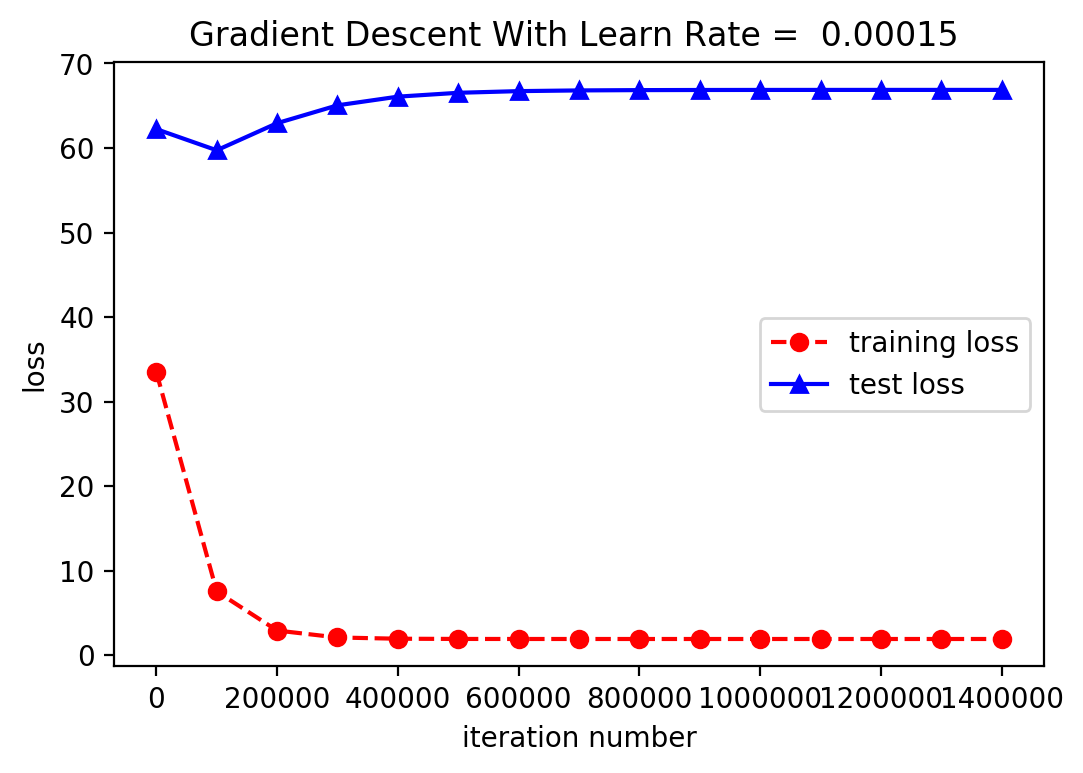

In [52]:
def train(w0,
          X,
          y,
          learn_rate,
          iter_times,
          record_iterval,
          verbose=False,
          stochastic=False):
    """
    train the leaner model
    - w0: initialization value
    - X, y: training data set, ground truth
    - iter_times, learn_rate, ...
    """
    err_train, err_test = [], []
    w, grad_w, sample_num = w0, None, training_X.shape[0]
    is_explode = False
    for i in range(1, iter_times + 1):
        if i % record_iterval == 0:
            # print('iterate number : {} / {}'.format(i, iter_times) )
            err_train.append(loss_func(w, training_X, training_y))
            err_test.append(loss_func(w, test_X, test_y))
        if stochastic:
            # 使用随机梯度下降，计算梯度的时候只使用一个样本
            r = np.random.randint(0, sample_num)
            grad_w = get_gradient(w, X[r].reshape(1, -1), y[r].reshape(1, -1))
        else:
            grad_w = get_gradient(w, X, y)
        if np.sum(np.abs(grad_w)) > 1e10:
            # break if the gradient explode
            is_explode = True
            break
        if verbose:
            print("iter_num = ", i, "  w : ", w0.reshape(-1), " gradient: ",
                  grad_w.reshape(-1))
        w -= learn_rate * grad_w
    return w, err_train, err_test, is_explode


# const data
it, ri, lr = 1500000, 100000, 0.00015
w, err_train, err_test, is_explode = train(
    np.zeros((feature_num + 1, 1)),
    training_X,
    training_y,
    learn_rate=lr,
    iter_times=it,
    record_iterval=ri)
sample_point = [x * ri for x in range(len(err_train))]

plt.plot(sample_point, err_train, 'ro--', label='training loss')
plt.plot(sample_point, err_test, 'b^-', label='test loss')
plt.legend()
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.title("Gradient Descent With Learn Rate =  {} ".format(lr))
plt.show()

### 简单分析

从上面的图可以看出得出以下简单的结论：

- 随着迭代次数的增加，训练误差不断下降，前期下降的比较快，后面趋于收敛。

- 随着迭代次数的增加，测试先下降之后上升，可以看出，随着训练的进行，模型出现了过拟合的情况，导致模型的 `泛化` 的能力下降从而导致误差上升。

## exercise 2

> 现在，你改变学习率，比如把学习率改成0.0002（此时，你可以保持相同的迭代次数也可以改变迭代次数），然后训练该回归模型。你有什么发现？请简单分析。

### 实验流程

根据要求，改变学习率为 0.0002，增加了学习率，保持迭代次数不变，按照方法，经过实验发现【可以通过更改训练的接口中的 verbose 参数，来输出每次迭代的计算得到的梯度】，迭代到不到 1000 次的时候，梯度就发生了溢出，把未发生溢出之前的结果答应出来如下所示。

学习率为 0.0002, 迭代次数为 : 2500000 === 发生溢出!!


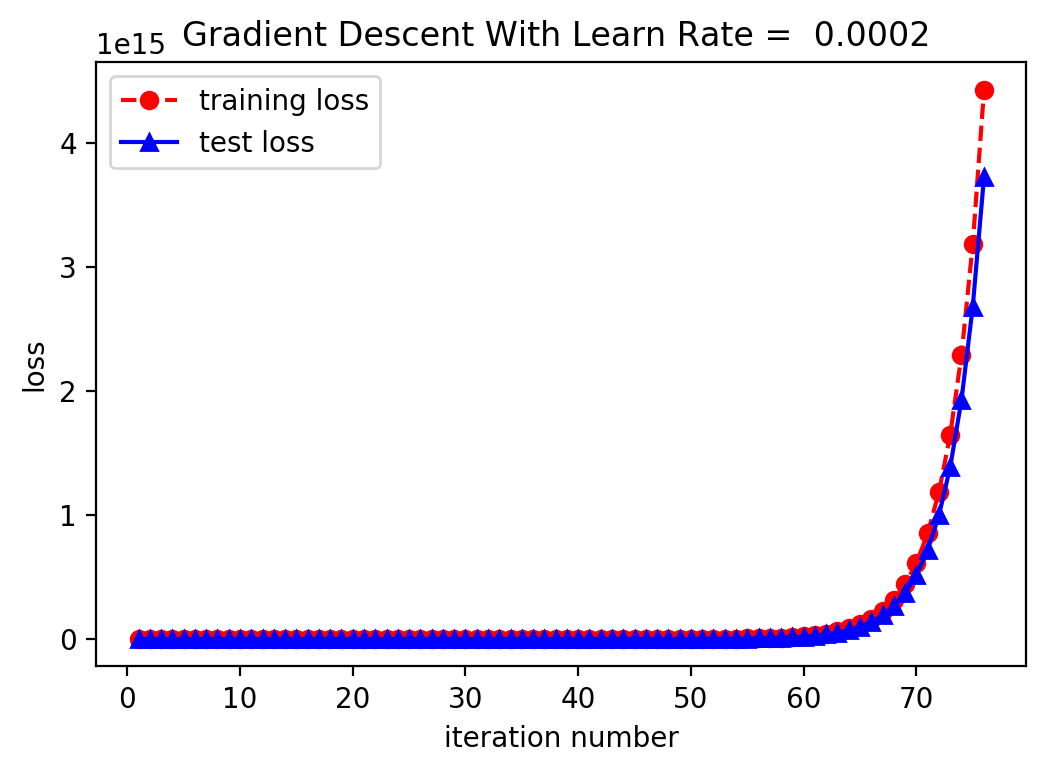

In [54]:
lr_list, it_list, ri = [0.0002], [200], 1
for lr in lr_list:
    w, err_train, err_test, is_explode = train(
            np.zeros((feature_num + 1, 1)), 
            training_X,
            training_y,
            learn_rate = lr,
            iter_times = it,
            record_iterval= ri,
            verbose = False
        )
    if is_explode:
        print("学习率为 {}, 迭代次数为 : {} === 发生溢出!!".format(lr, it))
    sample_point = np.array([ri* (x + 1) for x in range(len(err_train))])
    plt.plot(sample_point, err_train, 'ro--', label = 'training loss')
    plt.plot(sample_point, err_test, 'b^-', label = 'test loss')
    plt.legend()
    plt.xlabel("iteration number")
    plt.ylabel("loss")
    plt.title("Gradient Descent With Learn Rate =  {} ".format(lr))
    plt.show()


### 结果分析

- 从上述结果可以看到，在迭代到 70次左右的时候，loss 不仅没有下降反而是在一直上升，而且上升的呈现爆炸式增长，由于已经控制了其他的变量，只改变了学习率，可以推断出过高的学习率并不能够加快梯度下降的速度，反而可能导致 loss 和 梯度 爆炸性上升。

- 群内有同学提及到需要先给数据进行归一化(min-max normalization / z-score normalization)，这个对数据的训练有所帮助，能够增强梯度下降的稳定性。训练出来的参数，归一化之后，我们需要重新定义一下度量两个模型的函数。不过从题目的要求来看是要寻找学习率和学习效果之间的关系，所以应该控制和第一题之间的变量，综上不在这里进行标准化过程。


## exercise 3

> 现在，我们使用其他方法来获得最优的参数。你是否可以用随机梯度下降法获得最优的参数？请使用随机梯度下降法画出迭代次数（每K次，这里的K你自己设定）与训练样本和测试样本对应的误差的图。比较Exercise 1中的实验图，请总结你的发现。


### 随机梯度下降

首先需要实现随机梯度下降，大概的实现流程是是使用在每次计算梯度的时候不是把整个样本空间都累加起来计算梯度，而是从样本空间在随机选择 __一个__ 训练集的样本空间，进行梯度的计算。

### 训练结果

这里的训练采用使用了随机梯度下降的下降的方法，通过更改学习率和迭代步数，这里使用了4种学习率和迭代步数的组合，分别查看训练过程。

final parameter w[b, w1, w2] ::  [[ 57.97816297   6.99445097 -72.6245984 ]]


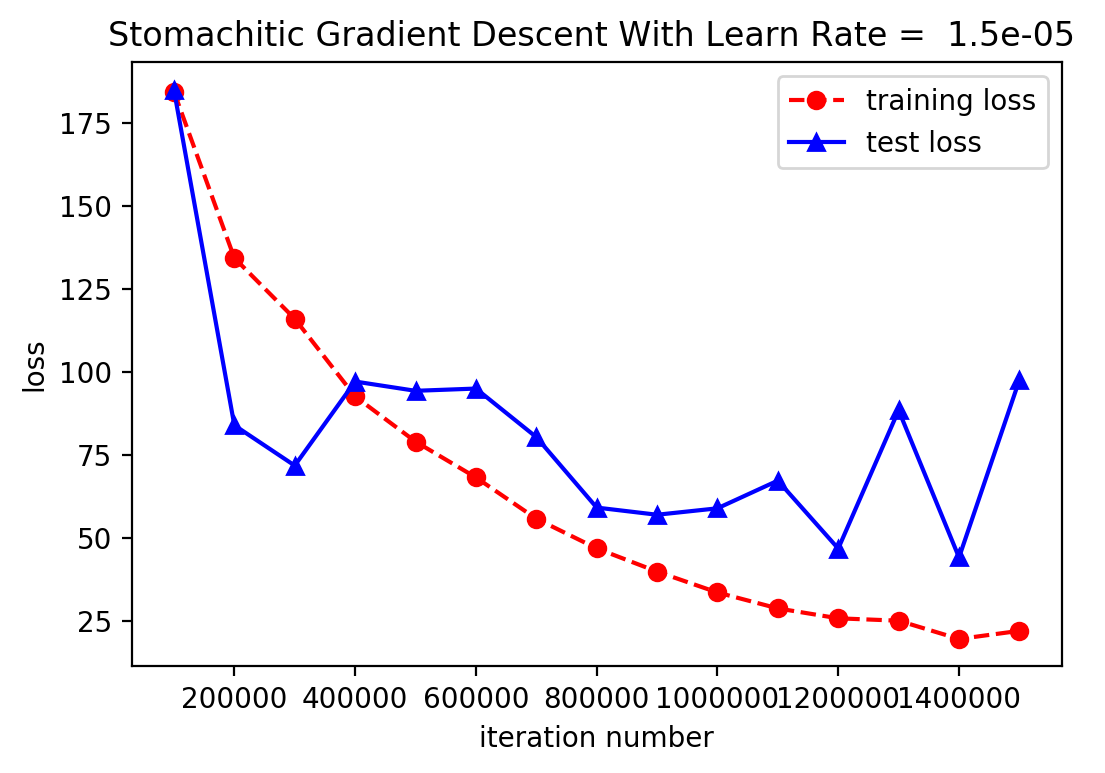

final parameter w[b, w1, w2] ::  [[ 70.39598123   6.86601343 -72.48552474]]


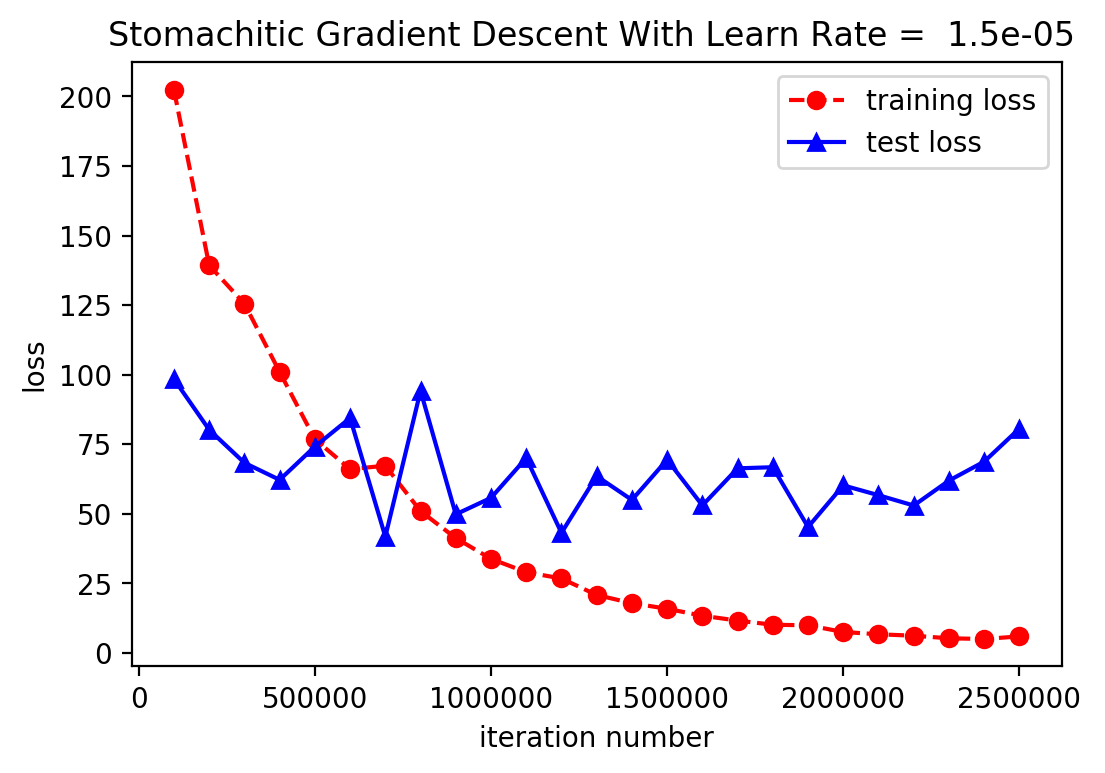

学习率为 0.0002, 迭代次数为 : 1500000 === 发生溢出!!
学习率为 0.0002, 迭代次数为 : 2500000 === 发生溢出!!


In [53]:
# 随机梯度下降
lr, it, ri = 0.000015, 2500000, 100000
lr_list, it_list = [0.000015, 0.0002], [1500000, 2500000]
for lr in lr_list:
    for it in it_list:
        w, err_train, err_test, is_explode = train(
            np.zeros((feature_num + 1, 1)),
            training_X,
            training_y,
            learn_rate=lr,
            iter_times=it,
            record_iterval=ri,
            verbose=False,
            stochastic=True)
        if is_explode:
            print("学习率为 {}, 迭代次数为 : {} === 发生溢出!!".format(lr, it))
        else:
            sample_point = np.array(
                [ri * (x + 1) for x in range(len(err_train))])
            print("final parameter w[b, w1, w2] :: ", w.reshape(1, -1))
            plt.plot(sample_point, err_train, 'ro--', label='training loss')
            plt.plot(sample_point, err_test, 'b^-', label='test loss')
            plt.legend()
            plt.xlabel("iteration number")
            plt.ylabel("loss")
            plt.title("Stomachitic Gradient Descent With Learn Rate =  {} ".format(lr))
            plt.show()

### 结果分析

综合以上的4个随机梯度下降的结果，我们能得到以下结论：

- 从上述的结果中我们可以看到使用随机梯度下降之后，相比直接使用梯度下降，迭代的步数增加了，但是训练的时间下降了，因为每次进行迭代的时间减少了。

- 在 250000 步迭代的图中，可以看出，迭代步数的增加，让训练误差下降到使用梯度下降的最优参数的水平，同时训练误差出现了反弹，出现了过拟合的现象。

- 使用随机梯度下降，迭代的稳定性不如使用梯度下降，会出现振荡的情况，这个情况出现的原因应该是使用随机梯度下降得到的梯度并非是 loss 函数下降的最快的方向，所以结果不是太稳定。

- 通过适当增加迭代的步数，可以让随机梯度下降达到最好的结果。

- 另外即使是使用了随机梯度下降，在过高的学习率的情况下，仍然出现了 loss 上升到溢出的情况。